# get percent of UNKNOWN vaccine type

In [29]:
import pandas as pd

# Assuming you have your datasets in a specified directory
base_path = "/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/"

total_vax_reports = 0
unk_vax_reports = 0

for year in range(1990, 2024):
    vax_file_path = f"{base_path}{year}VAERSVAX.csv"
    
    try:
        # Load vaccine data
        vax_df = pd.read_csv(vax_file_path, encoding='ISO-8859-1')

        # Update counts
        total_vax_reports += len(vax_df)
        unk_vax_reports += len(vax_df[vax_df['VAX_TYPE'] == "UNK"])

    except FileNotFoundError:
        print(f"File not found for year {year}.")
    except Exception as e:
        print(f"An error occurred for year {year}: {e}")

# Calculating the percentage
if total_vax_reports > 0:
    unk_percentage = (unk_vax_reports / total_vax_reports) * 100
    print(f"Percentage of VAERS reports with VAX_TYPE as 'UNK': {unk_percentage:.2f}%")
else:
    print("No vaccine reports found.")


Percentage of VAERS reports with VAX_TYPE as 'UNK': 1.10%


# Most common symptoms from 1990 to 2023

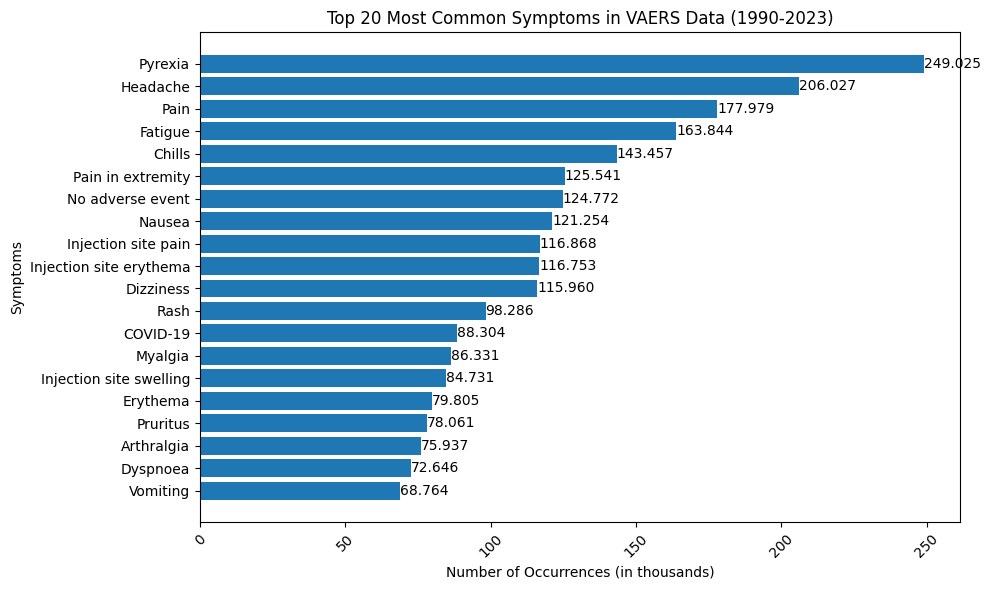

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

all_years_symptoms = pd.DataFrame()
for year in range(1990, 2024):
    file_path = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSSYMPTOMS.csv"
    yearly_symptoms_df = pd.read_csv(file_path, encoding='ISO-8859-1')
    all_years_symptoms = pd.concat([all_years_symptoms, yearly_symptoms_df])

all_symptoms = pd.concat([all_years_symptoms['SYMPTOM1'], all_years_symptoms['SYMPTOM2'], 
                          all_years_symptoms['SYMPTOM3'], all_years_symptoms['SYMPTOM4'], 
                          all_years_symptoms['SYMPTOM5']])

most_common_symptoms = all_symptoms.value_counts().head(20)

plt.figure(figsize=(10, 6))
bars = plt.barh(most_common_symptoms.index, most_common_symptoms.values)

plt.title('Top 20 Most Common Symptoms in VAERS Data (1990-2023)')
plt.xlabel('Number of Occurrences (in thousands)')
plt.ylabel('Symptoms')

# Adding the text inside the bars
for bar in bars:
    label = f'{bar.get_width():,.0f}'.replace(',', '.')  # Format the number with a dot as a thousands separator
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             label, 
             va='center', ha='left', color='black')

plt.gca().invert_yaxis()  # Invert y-axis to have the most common symptom at the top

# Format x-axis labels in thousands
def format_thousands(x, pos):
    return f'{x/1000:.0f}'

formatter = FuncFormatter(format_thousands)
plt.gca().xaxis.set_major_formatter(formatter)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Symptoms/Top20Symptoms_alltime.png')
plt.show()

# most common symptoms excluding UNK vaccine type

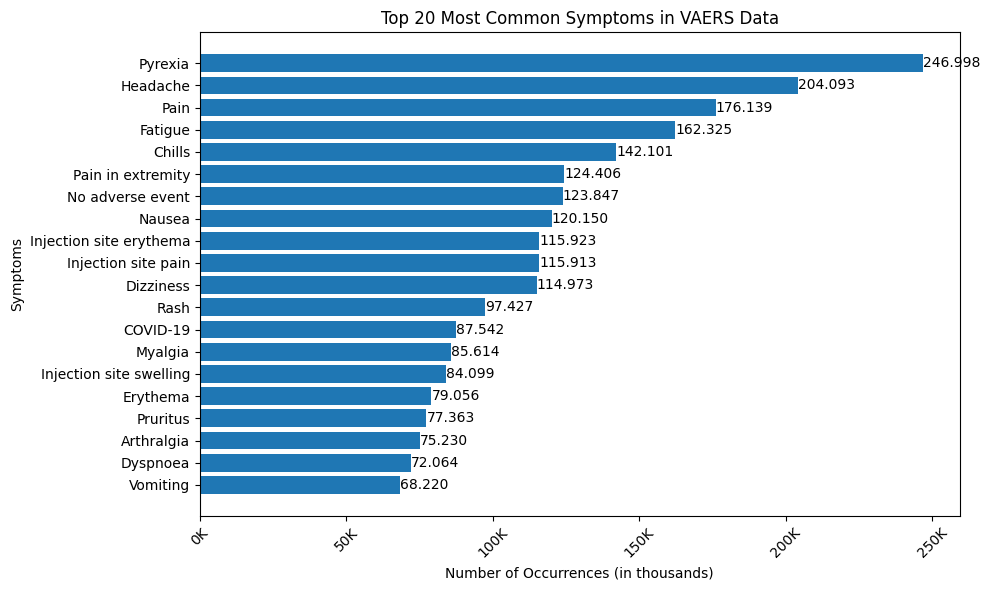

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

all_years_symptoms = pd.DataFrame()

for year in range(1990, 2024):
    symptoms_file_path = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSSYMPTOMS.csv"
    vax_file_path = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSVAX.csv"
    
    try:
        # Load symptoms and vaccine data
        symptoms_df = pd.read_csv(symptoms_file_path, encoding='ISO-8859-1')
        vax_df = pd.read_csv(vax_file_path, encoding='ISO-8859-1', usecols=['VAERS_ID', 'VAX_TYPE'])
        vax_df = vax_df.drop_duplicates(subset=['VAERS_ID'])  # Drop duplicate VAERS_IDs
    
        # Merge and exclude records where VAX_TYPE is 'UNK'
        merged_df = pd.merge(symptoms_df, vax_df, on='VAERS_ID')
        filtered_df = merged_df[merged_df['VAX_TYPE'] != "UNK"]

        all_years_symptoms = pd.concat([all_years_symptoms, filtered_df])

    except FileNotFoundError:
        print(f"File not found for year {year}.")
    except Exception as e:
        print(f"An error occurred for year {year}: {e}")

# Combine all symptom columns
all_symptoms = pd.concat([
    all_years_symptoms['SYMPTOM1'], all_years_symptoms['SYMPTOM2'],
    all_years_symptoms['SYMPTOM3'], all_years_symptoms['SYMPTOM4'],
    all_years_symptoms['SYMPTOM5']
])

# Count the occurrences of each symptom
most_common_symptoms = all_symptoms.value_counts().head(20)

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(most_common_symptoms.index, most_common_symptoms.values)

plt.title('Top 20 Most Common Symptoms in VAERS Data')
plt.xlabel('Number of Occurrences (in thousands)')
plt.ylabel('Symptoms')

# Adding the text inside the bars
for bar in bars:
    label = f'{bar.get_width():,.0f}'.replace(',', '.')  # Format the number with a dot as a thousands separator
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             label, 
             va='center', ha='left', color='black')

plt.gca().invert_yaxis()  # Invert y-axis to have the most common symptom at the top

# Format x-axis labels in thousands
formatter = FuncFormatter(lambda x, pos: f'{int(x/1000)}K')
plt.gca().xaxis.set_major_formatter(formatter)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Symptoms/Top20Symptoms_ExcludingUNK.png')
plt.show()


# Now for people that got vaccinated with the COVID-19 vaccine

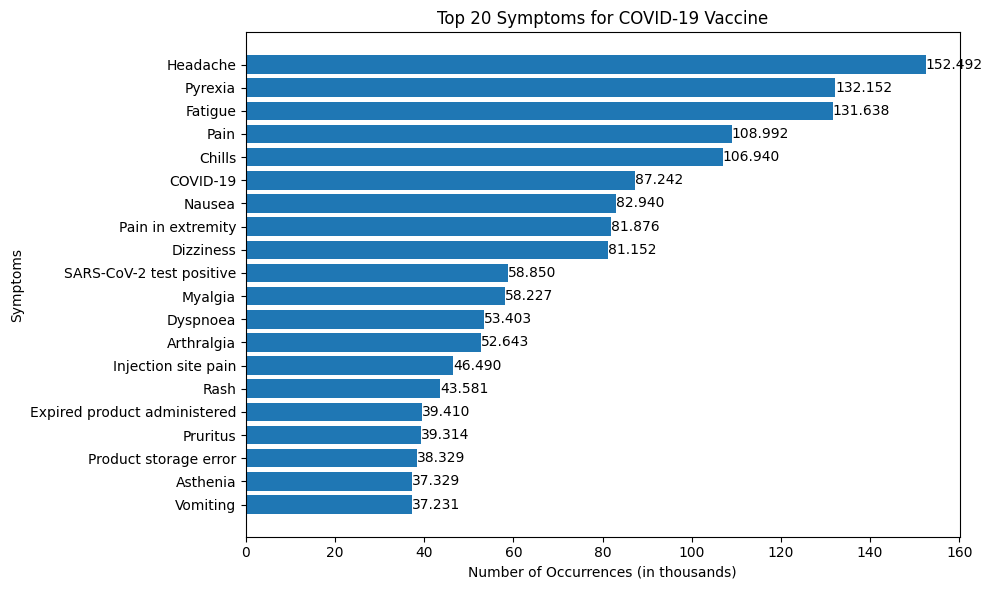

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have your datasets in a specified directory
base_path = "/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/"

all_covid_symptoms = pd.DataFrame()

for year in range(2020, 2024):
    vax_file_path = f"{base_path}{year}VAERSVAX.csv"
    symptoms_file_path = f"{base_path}{year}VAERSSYMPTOMS.csv"
    
    # Load vaccine data
    vax_df = pd.read_csv(vax_file_path, encoding='ISO-8859-1')
    vax_df = vax_df.drop_duplicates(subset=['VAERS_ID'])  

    # Filter for any VAX_TYPE that contains "COVID"
    covid_vax_ids = vax_df[vax_df['VAX_TYPE'].str.contains("COVID", na=False)]['VAERS_ID']

    # Load symptoms data and filter based on COVID vaccine IDs
    symptoms_df = pd.read_csv(symptoms_file_path, encoding='ISO-8859-1')
    covid_symptoms_df = symptoms_df[symptoms_df['VAERS_ID'].isin(covid_vax_ids)]
    
    # Combine all symptom columns
    covid_all_symptoms = pd.concat([covid_symptoms_df['SYMPTOM1'], covid_symptoms_df['SYMPTOM2'], 
                                    covid_symptoms_df['SYMPTOM3'], covid_symptoms_df['SYMPTOM4'], 
                                    covid_symptoms_df['SYMPTOM5']])
    all_covid_symptoms = pd.concat([all_covid_symptoms, covid_all_symptoms])

# Counting the occurrences of each symptom
most_common_covid_symptoms = all_covid_symptoms.value_counts().head(20)

# Convert the Series to a DataFrame
df = most_common_covid_symptoms.reset_index()
df.columns = ['Symptom', 'Count']

# Sorting the DataFrame
df = df.sort_values(by='Count', ascending=True)

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(df['Symptom'], df['Count'] / 1000)  # Divide the count by 1000 to convert to thousands

# Adding labels and title
plt.xlabel('Number of Occurrences (in thousands)')
plt.ylabel('Symptoms')
plt.title('Top 20 Symptoms for COVID-19 Vaccine')

# Adding the text inside the bars with thousands separator
for bar in bars:
    label = f'{bar.get_width():,.3f}'.replace(',', '.')  # Format the number with a dot as a thousands separator
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             label, 
             va='center', ha='left', color='black')

plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Symptoms/Top20Symptoms_COVID.png')
plt.show()


# Now for every other vaccine besides COVID-19

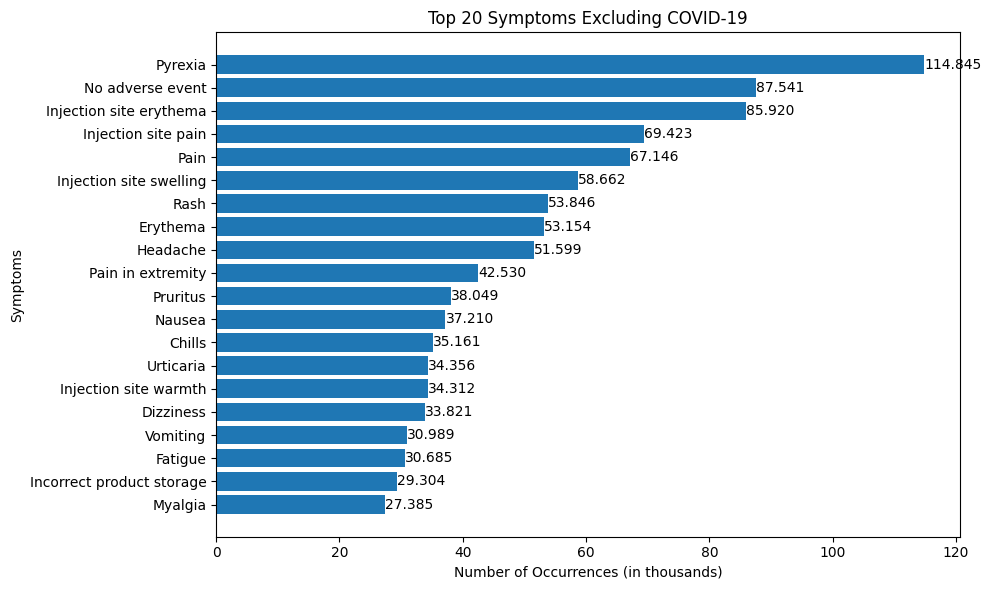

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have your datasets in a specified directory
base_path = "/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/"

all_non_covid_and_unknown_symptoms = pd.DataFrame()

for year in range(1990, 2024):  # Adjust the years as per your data availability
    vax_file_path = f"{base_path}{year}VAERSVAX.csv"
    symptoms_file_path = f"{base_path}{year}VAERSSYMPTOMS.csv"
    
    # Load vaccine data
    vax_df = pd.read_csv(vax_file_path, encoding='ISO-8859-1')
    vax_df = vax_df.drop_duplicates(subset=['VAERS_ID'])

    # Exclude any VAX_TYPE that contains "COVID" or is "UNK"
    non_covid_or_unknown_vax_ids = vax_df[~vax_df['VAX_TYPE'].str.contains("COVID", na=False) & 
                                          (vax_df['VAX_TYPE'] != "UNK")]['VAERS_ID']

    # Load symptoms data and filter based on non-COVID-19 and non-unknown vaccine IDs
    symptoms_df = pd.read_csv(symptoms_file_path, encoding='ISO-8859-1')
    non_covid_or_unknown_symptoms_df = symptoms_df[symptoms_df['VAERS_ID'].isin(non_covid_or_unknown_vax_ids)]
    
    # Combine all symptom columns
    non_covid_or_unknown_all_symptoms = pd.concat([
        non_covid_or_unknown_symptoms_df['SYMPTOM1'], non_covid_or_unknown_symptoms_df['SYMPTOM2'], 
        non_covid_or_unknown_symptoms_df['SYMPTOM3'], non_covid_or_unknown_symptoms_df['SYMPTOM4'], 
        non_covid_or_unknown_symptoms_df['SYMPTOM5']
    ])
    all_non_covid_and_unknown_symptoms = pd.concat([all_non_covid_and_unknown_symptoms, non_covid_or_unknown_all_symptoms])

# Counting the occurrences of each symptom
most_common_non_covid_and_unknown_symptoms = all_non_covid_and_unknown_symptoms.value_counts().head(20)

# Convert the Series to a DataFrame
df = most_common_non_covid_and_unknown_symptoms.reset_index()
df.columns = ['Symptom', 'Count']

# Sorting the DataFrame
df = df.sort_values(by='Count', ascending=True)

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(df['Symptom'], df['Count'] / 1000)  # Divide the count by 1000 to convert to thousands

# Adding labels and title
plt.xlabel('Number of Occurrences (in thousands)')
plt.ylabel('Symptoms')
plt.title('Top 20 Symptoms Excluding COVID-19')

# Adding the text inside the bars with thousands separator
for bar in bars:
    label = f'{bar.get_width():,.3f}'.replace(',', '.')  # Format the number with a dot as a thousands separator
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             label, 
             va='center', ha='left', color='black')

plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Symptoms/Top20Symptoms_ExcludingCOVID.png')
plt.show()
